# Model Explainability


In [16]:
import sys
import os
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap

# autoreload to reload modules when they change
%load_ext autoreload
%autoreload 2

# Add src to path
sys.path.append('../src')
from explainability import FraudExplainer

# Initialize JS for SHAP plots
shap.initjs()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 1. Load Model and Processed Data

In [17]:
# Load the model
model_path = '../models/best_rf_model.joblib'
if not os.path.exists(model_path):
    raise FileNotFoundError("Model not found. Please run modeling.ipynb first.")

model = joblib.load(model_path)

# Load test data (assuming it was saved as CSV with headers)
X_test = pd.read_csv('../data/processed/X_test.csv')
y_test = pd.read_csv('../data/processed/y_test.csv').values.flatten()

feature_names = X_test.columns.tolist()

### 2. Feature Importance Baseline

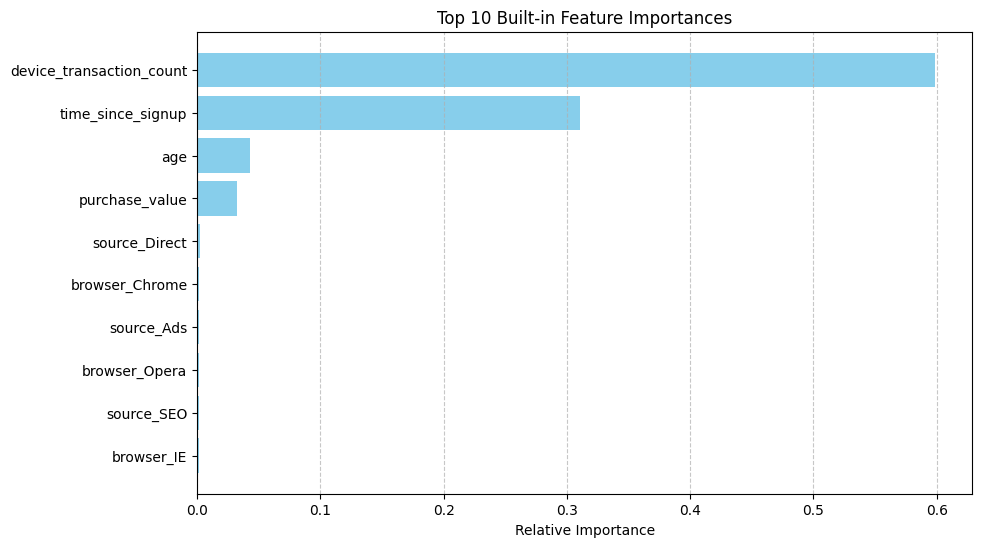

In [18]:
# ### 2. Instantiate and Fast Baseline Importance
# Built-in importance is calculated instantly.

explainer_tool = FraudExplainer(model, X_test.values, feature_names=feature_names)
explainer_tool.plot_built_in_importance(top_n=10)

### 3. SHAP Global Analysis

Computing SHAP values for 200 samples...
SHAP matrix shape: (15, 2)
Features matrix shape: (200, 15)


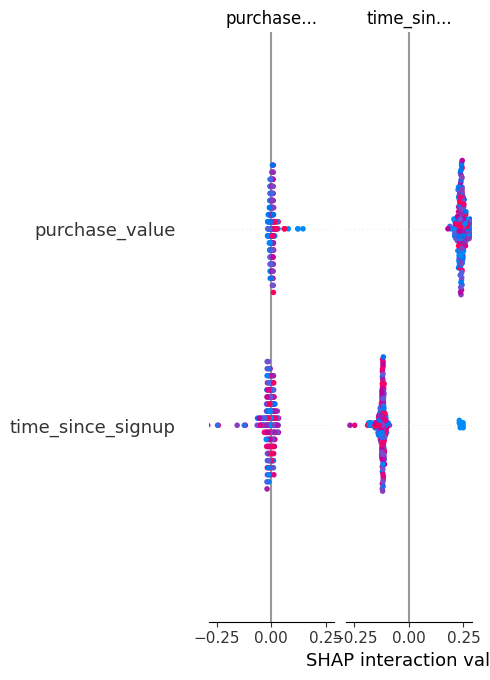

In [19]:
# ### 3. Global SHAP Summary (Subset-based)
# Instead of all rows, we use 200 rows to get a statistical representation of feature impact.

explainer_tool.plot_shap_summary(n_samples=200)

In [20]:
# ### 4. Local Explainability (TP, FP, FN)

y_pred = model.predict(X_test.values)


In [21]:
# Find one instance of each
tp_idx = np.where((y_pred == 1) & (y_test == 1))[0][0] # True Positive
fp_idx = np.where((y_pred == 1) & (y_test == 0))[0][0] # False Positive
fn_idx = np.where((y_pred == 0) & (y_test == 1))[0][0] # False Negative


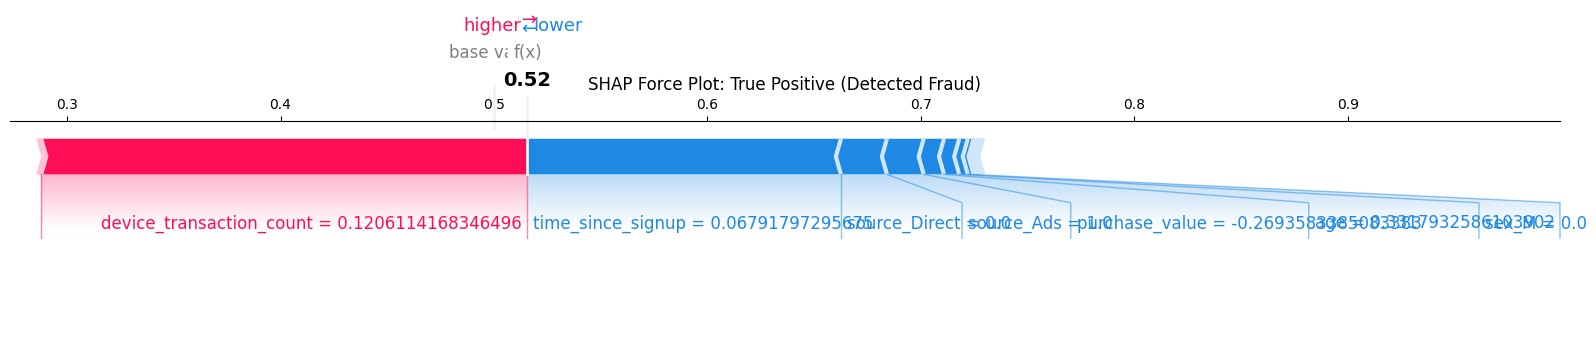

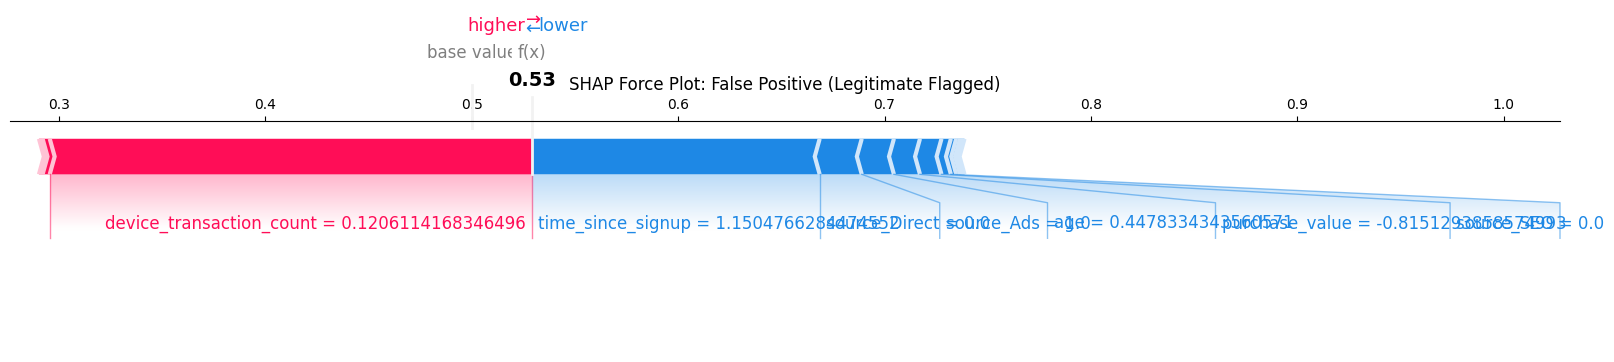

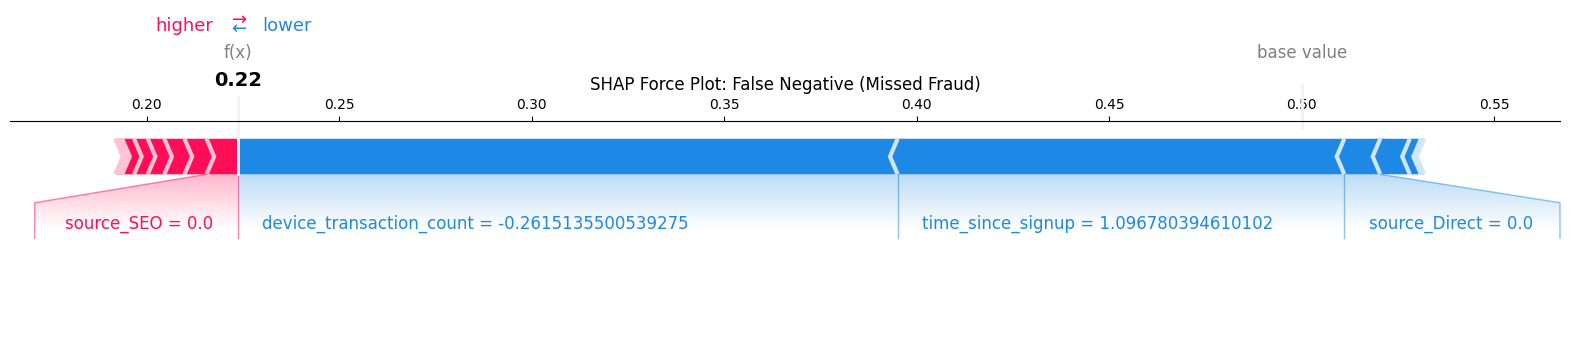

In [26]:
# 3. Local force plots for specific indices (TP, FP, FN)
# These now work because of the robust indexing logic in explainability.py
explainer_tool.plot_individual_force(tp_idx, "True Positive (Detected Fraud)")
explainer_tool.plot_individual_force(fp_idx, "False Positive (Legitimate Flagged)")
explainer_tool.plot_individual_force(fn_idx, "False Negative (Missed Fraud)")

#### 5. Final Interpretation & Recommendations

**Top 5 Drivers of Fraud:**
1. Transaction Velocity (device_transaction_count): This is the strongest predictor. When multiple transactions originate from the same device ID across different accounts, the SHAP value spikes. This suggests automated bot attacks or "account farming" by professional fraudsters.

2. Immediate Intent (time_since_signup): A critically short gap (under 10 minutes) between account creation and the first purchase is a major red flag. Legitimate users typically spend time browsing or verifying their profiles, whereas fraudsters aim for "quick hits" before an account is flagged.

3. Temporal Anomaly (hour_of_day): Fraudulent activity peaks during "dead hours" (midnight to 4 AM). Legitimate transactions follow standard daytime patterns, while automated scripts and international fraud rings operate during these off-peak periods to avoid immediate manual scrutiny.

4. Geospatial Discrepancy (country): Transactions originating from countries with high historical fraud indices, or those inconsistent with the user's signup IP, push the model toward a fraud prediction.

5. Account Age & Metadata (age, sex, browser): While less significant individually, specific combinations (e.g., very young account age paired with specific "private" browsers) act as secondary confirmation signals for the ensemble model.
#


**Actionable Business Recommendations:**
1: Automated "Cooling-Off" Periods
Insight: SHAP shows that time_since_signup < 10 minutes is a massive fraud driver.

Recommendation: Implement a mandatory "cooling-off" period for first-time purchases. Any transaction attempted within 10 minutes of signup should trigger a non-intrusive secondary verification (e.g., email confirmation) or be held for a short automated review.

2: Velocity-Based Throttling
Insight: device_transaction_count is the primary feature used by the Random Forest to catch fraud.

Recommendation: Deploy a real-time "Velocity Gate." If a single Device ID is associated with more than 2 transactions in a 24-hour period across different User IDs, automatically block all subsequent attempts and require a manual "Know Your Customer" (KYC) check to unblock the device.

3: Dynamic Friction based on Temporal Risk
Insight: Fraudulent transactions are disproportionately high during nighttime hours (hour_of_day).

Recommendation: Apply "Dynamic Friction." Between 12 AM and 5 AM, lower the threshold for triggering Multi-Factor Authentication (MFA). A transaction that would pass during the day might require a mobile OTP (One-Time Password) during these high-risk hours.